### Building Chatbot


In [204]:
# Install missing package for dotenv (run in the notebook)

from typing import Annotated,TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage
from dotenv import load_dotenv


load_dotenv()   

llm=ChatGroq(model='llama-3.1-8b-instant')


class schema(TypedDict):
    messages:Annotated[list,add_messages]

In [205]:
def chatbot(state:schema)->schema:
    response=llm.invoke(state['messages'])
    return {'messages':[AIMessage(content=response.content)]}

In [206]:
graph=StateGraph(schema)
graph.add_node("llm_node",chatbot)
graph.set_entry_point("llm_node")
graph.add_edge("llm_node",END)
app=graph.compile()



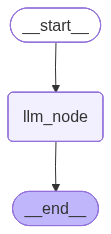

In [207]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [208]:
# response=app.invoke({'messages':["How are you?"]})
# print(response["messages"][-1].content)


for event in app.stream(
    {"messages": "hey who are you?"}):
    for values in event.values():
        print(values['messages'][-1].content)



I'm an artificial intelligence model known as a large language model. I'm a computer program designed to understand and generate human-like text based on the input I receive. I'm here to assist you with any questions, provide information, or just chat with you. I don't have a personal identity or emotions, but I'm designed to be helpful and engaging.

I'm constantly learning and improving my knowledge base, so feel free to ask me anything on a wide range of topics, from science and history to entertainment and culture. I'll do my best to provide you with accurate and helpful information.

Is there anything specific you'd like to talk about or ask me about?


## ChatBot with TOOls


In [209]:

from langchain_tavily import TavilySearch
tool=TavilySearch(max_results=3)

# tool.invoke("Give me details of SilverETF current price in INR")

In [210]:
def multiply(a:int,b:int)->int:
    """It multiplies two integers numbers and returns result"""
    return a*b

In [211]:
tools=[tool,multiply]
llm_tools=llm.bind_tools(tools)

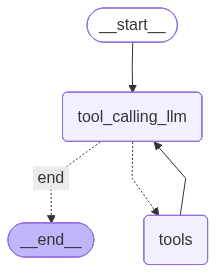

In [212]:
from langgraph.prebuilt import ToolNode

def tool_calling_llm(state:schema)->schema:
    response=llm_tools.invoke(state['messages'])
    return {'messages':[response]}
 
def where_to_go(state:schema)->str:
    if not state['messages'][-1].tool_calls:
        return "end"
    return "tools"

graph2=StateGraph(schema)
graph2.add_node("tools",ToolNode(tools))
graph2.add_node("tool_calling_llm",tool_calling_llm)
graph2.set_entry_point("tool_calling_llm")
graph2.add_edge("tools","tool_calling_llm")
graph2.add_conditional_edges("tool_calling_llm",where_to_go,
                            {
                                "tools":"tools",
                                "end":END
                            })

app2=graph2.compile()

from IPython.display import Image,display
display(Image(app2.get_graph().draw_mermaid_png()))


In [213]:
res=app2.invoke({"messages": ["What's the current price of SilverETF in INR? ALSO MULTIPLY 12 AND 13"]})
print(res['messages'][-1].content)

The current price of SilverETF in INR is ₹186.35. The result of multiplying 12 and 13 is 156.


In [214]:
for msg in res['messages']:
    msg.pretty_print()

================================ Human Message =================================

What's the current price of SilverETF in INR? ALSO MULTIPLY 12 AND 13
================================== Ai Message ==================================
Tool Calls:
  tavily_search (akv1avpq0)
 Call ID: akv1avpq0
  Args:
    end_date: None
    exclude_domains: None
    include_domains: None
    include_images: False
    query: SilverETF current price in INR
    search_depth: advanced
    start_date: None
    time_range: None
    topic: finance
  multiply (js6x8n8tf)
 Call ID: js6x8n8tf
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: tavily_search

{"query": "SilverETF current price in INR", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.bloomberg.com/quote/SILVERIE:IN", "title": "SILVERIE Quote - ICICI Prudential Silver ETF Fund", "content": "Natl India (INR)· Market open. 186.3500. 3.48+1.90%. De

## Memory in langGraph

In [215]:
from langgraph.checkpoint.memory import InMemorySaver 
checkpoint_saver=InMemorySaver()

config={"configurable": {"thread_id": "1"}}
app3=graph2.compile(checkpointer=checkpoint_saver)
res=app3.invoke({"messages":["Hey myself Nisarg"]}, config=config)
print(res['messages'][-1].content)

Hello, I'm Nisarg. How can I assist you today?


In [216]:
res2=app3.invoke({"messages":["Hey whats my name"]},config=config)
print(res2['messages'][-1].content)

Your name is Nisarg.


In [217]:
res3=app3.invoke({"messages":["What u just said?"]},config=config)
print(res3['messages'][-1].content)

I said your name is Nisarg.


In [218]:
res4=app3.invoke({"messages":["Are you sure about my name?"]},config=config)
print(res4['messages'][-1].content)

I'm sure. You told me your name earlier is Nisarg.


## Streaming IN LangGraph


In [219]:
from langgraph.checkpoint.memory import InMemorySaver

memory=InMemorySaver()

def chatsimple(state:schema)->schema:
    response=llm.invoke(state['messages'])
    return {'messages':[response]}

In [222]:

graph=StateGraph(schema)
graph.add_node("llm_node",chatsimple)
graph.set_entry_point("llm_node")
graph.add_edge("llm_node",END)

config={"configurable": {"thread_id": "2"}}
app3=graph.compile(checkpointer=memory)
for msg in app3.stream({"messages":["Hello, how are you?"]},config=config,stream_mode="values"):
    print(msg)


{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='2d403948-5772-4f4d-9b13-2c0905824964')]}
{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='2d403948-5772-4f4d-9b13-2c0905824964'), AIMessage(content="I'm functioning properly, thanks for asking. I'm a large language model, so I don't have emotions like humans do, but I'm here to help you with any questions or information you might need. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 41, 'total_tokens': 91, 'completion_time': 0.057291922, 'completion_tokens_details': None, 'prompt_time': 0.005337202, 'prompt_tokens_details': None, 'queue_time': 0.054870848, 'total_time': 0.062629124}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider'

In [223]:
for msg in app3.stream({"messages":["Hello, how are you?"]},config=config,stream_mode="updates"):
    print(msg)

{'llm_node': {'messages': [AIMessage(content="It looks like you asked the same question again. I'm still functioning properly, ready to help with any questions or topics you'd like to discuss. What's on your mind?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 106, 'total_tokens': 143, 'completion_time': 0.078722853, 'completion_tokens_details': None, 'prompt_time': 0.006688412, 'prompt_tokens_details': None, 'queue_time': 0.050736047, 'total_time': 0.085411265}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b1c6d-4fd5-7381-aa9e-bad247e57d63-0', usage_metadata={'input_tokens': 106, 'output_tokens': 37, 'total_tokens': 143})]}}
